In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [17]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  282 0 0 4 1972
	with hard mask.


In [18]:
ALPHA = 0.7

In [19]:
OMEGA = None

In [20]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Init proximal operator for main terms.
 |█████████-----------| 47.8%  - epoch_loss:  869.66 - epoch_recon_loss:  844.94 - epoch_kl_loss:   49.43 - val_loss:  936.64 - val_recon_loss:  911.32 - val_kl_loss:   50.63
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss:  872.38 - epoch_recon_loss:  847.49 - epoch_kl_loss:   49.78 - val_loss:  931.37 - val_recon_loss:  905.99 - val_kl_loss:   50.77
ADJUSTED LR
 |██████████----------| 54.8%  - epoch_loss:  873.97 - epoch_recon_loss:  849.13 - epoch_kl_loss:   49.68 - val_loss:  929.62 - val_recon_loss:  904.32 - val_kl_loss:   50.60
ADJUSTED LR
 |███████████---------| 58.0%  - epoch_loss:  870.09 - epoch_recon_loss:  845.29 - epoch_kl_loss:   49.60 - val_loss:  932.20 - val_recon_loss:  906.83 - val_kl_loss:   50.74
ADJUSTED LR
 |████████████--------| 60.8%  - epoch_loss:  870.81 - epoch_recon_loss:  846.01 - epoch_kl_loss:   49.60 - val_loss:  933.59 - val_recon_loss:  908.16 - val_kl_loss:   50.85
Stopping early: no improvement of more

In [21]:
#intr_cvae.save("ref_model_fig3")

In [22]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [23]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'TRIGLYCERIDE_BIOSYNTHESIS',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'TGF_BETA_RECEPTOR_SIGNALING_AC',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'CA_DEPENDENT_EVENTS',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_BETA_GAMMA_SIGNALLING_THROUG',
 'CD28_DEPENDENT_PI3K_AKT_SIGNAL',
 'G_PROTEIN_BETA_GAMMA_SIGNALLIN',
 'CTLA4_INHIBITORY_SIGNALING',
 'SIGNAL_AMPLIFICATION',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'RNA_POL_I_PROMOTER_OPENING',
 'REGULATION_OF_SIGNALING_BY_CBL

In [24]:
MEAN = False

In [25]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [26]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [27]:
sc.tl.umap(adata)

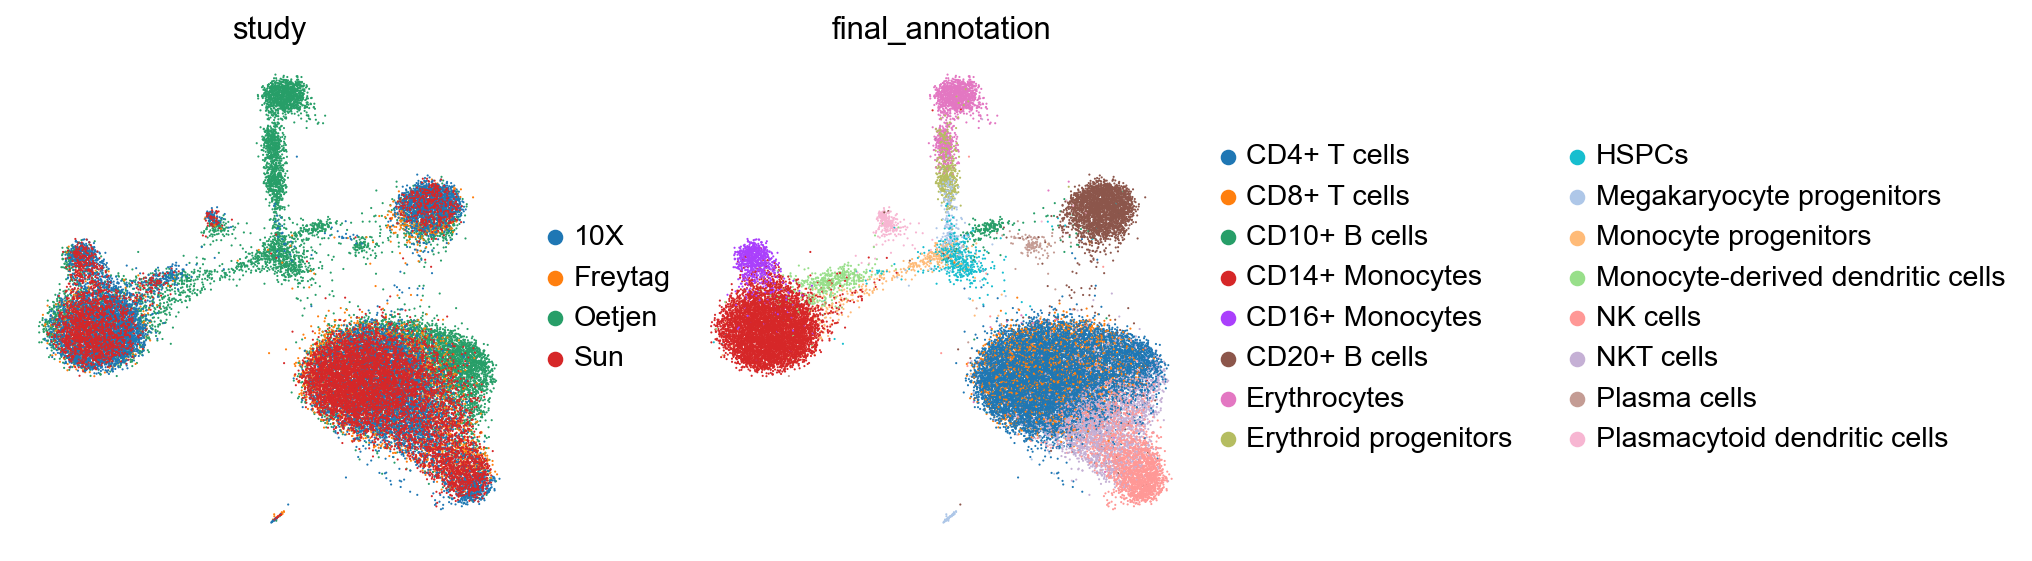

In [28]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [29]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [30]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [31]:
kang.obs['study'] = 'Kang'

In [32]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020', kang)

In [33]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  282 0 0 5 1972
	with hard mask.


In [34]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

 |███████-------------| 37.5%  - epoch_loss:  524.53 - epoch_recon_loss:  517.51 - epoch_kl_loss:   70.25 - val_loss:  522.69 - val_recon_loss:  515.61 - val_kl_loss:   70.78
ADJUSTED LR
 |████████------------| 40.2%  - epoch_loss:  521.83 - epoch_recon_loss:  514.78 - epoch_kl_loss:   70.42 - val_loss:  522.78 - val_recon_loss:  515.70 - val_kl_loss:   70.83
ADJUSTED LR
 |████████------------| 42.0%  - epoch_loss:  520.07 - epoch_recon_loss:  513.03 - epoch_kl_loss:   70.32 - val_loss:  521.66 - val_recon_loss:  514.59 - val_kl_loss:   70.69
ADJUSTED LR
 |████████------------| 43.5%  - epoch_loss:  521.60 - epoch_recon_loss:  514.55 - epoch_kl_loss:   70.46 - val_loss:  523.16 - val_recon_loss:  516.09 - val_kl_loss:   70.76
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 152


In [35]:
#q_intr_cvae.save('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020')

In [36]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [37]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [38]:
sc.tl.umap(kang)

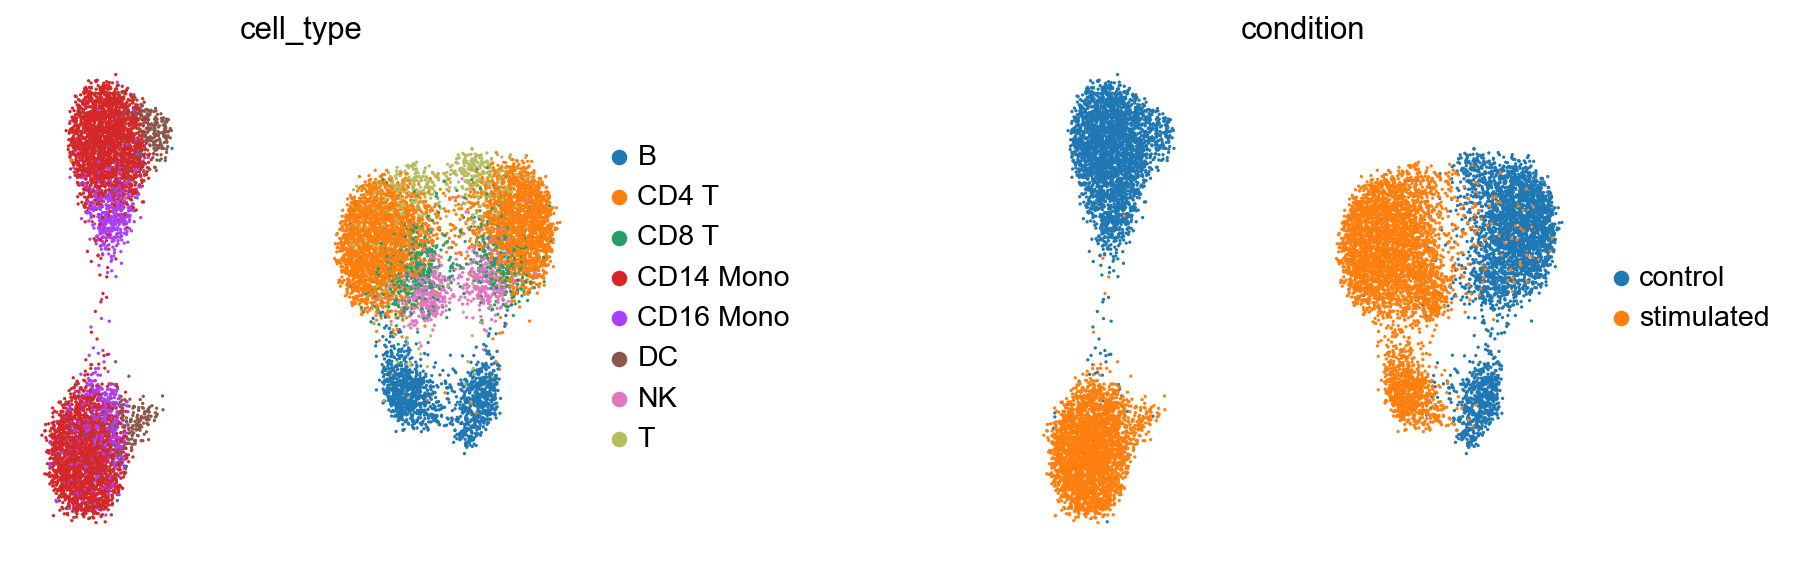

In [39]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [40]:
terms = adata.uns['terms']

In [41]:
scores_cond = q_intr_cvae.latent_enrich('condition', comparison="control", adata=kang, n_perm=7000, exact=True)

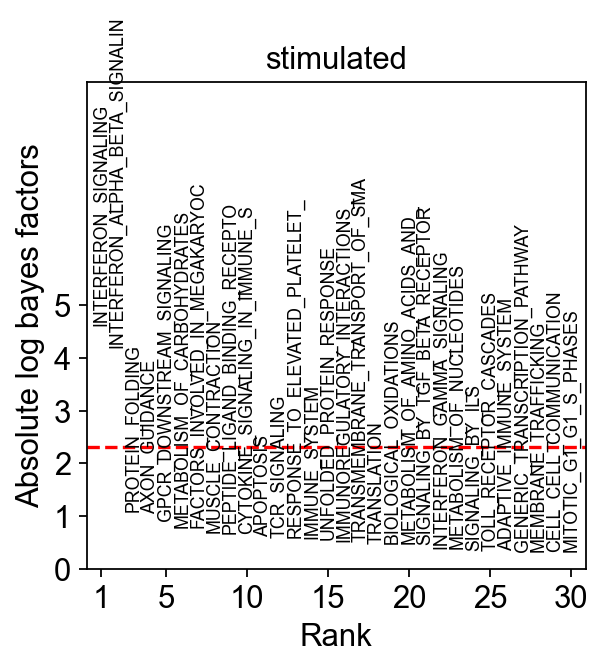

In [42]:
fig = sca.plotting.plot_abs_bfs(scores_cond, np.array(terms), keys='stimulated', yt_step=1, fontsize=8, scale_y=2)

In [43]:
scores_ct = q_intr_cvae.latent_enrich('cell_type', adata=kang, n_perm=7000, exact=True)

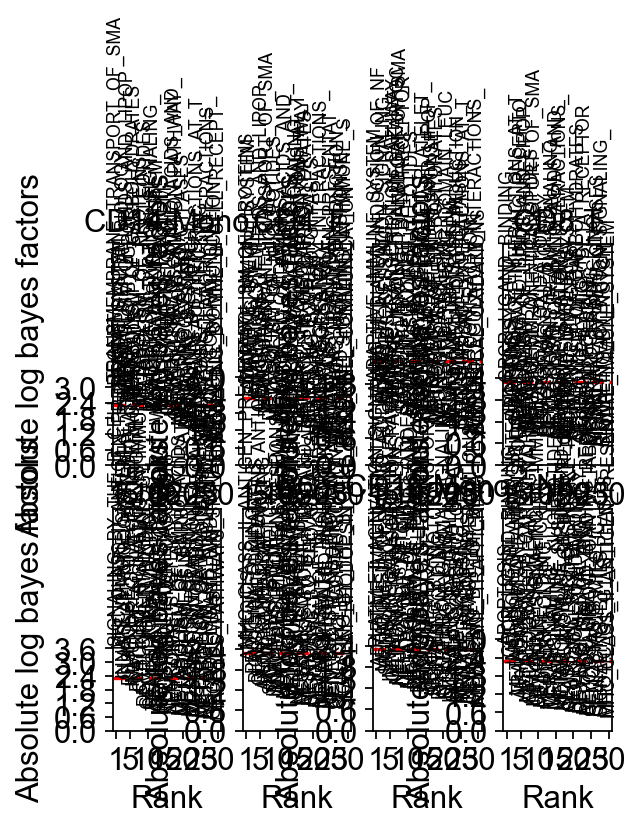

In [44]:
fig = sca.plotting.plot_abs_bfs(scores_ct, np.array(terms), n_cols=4, scale_y=2.6, yt_step=0.6)

In [45]:
fig.set_size_inches(24, 12)

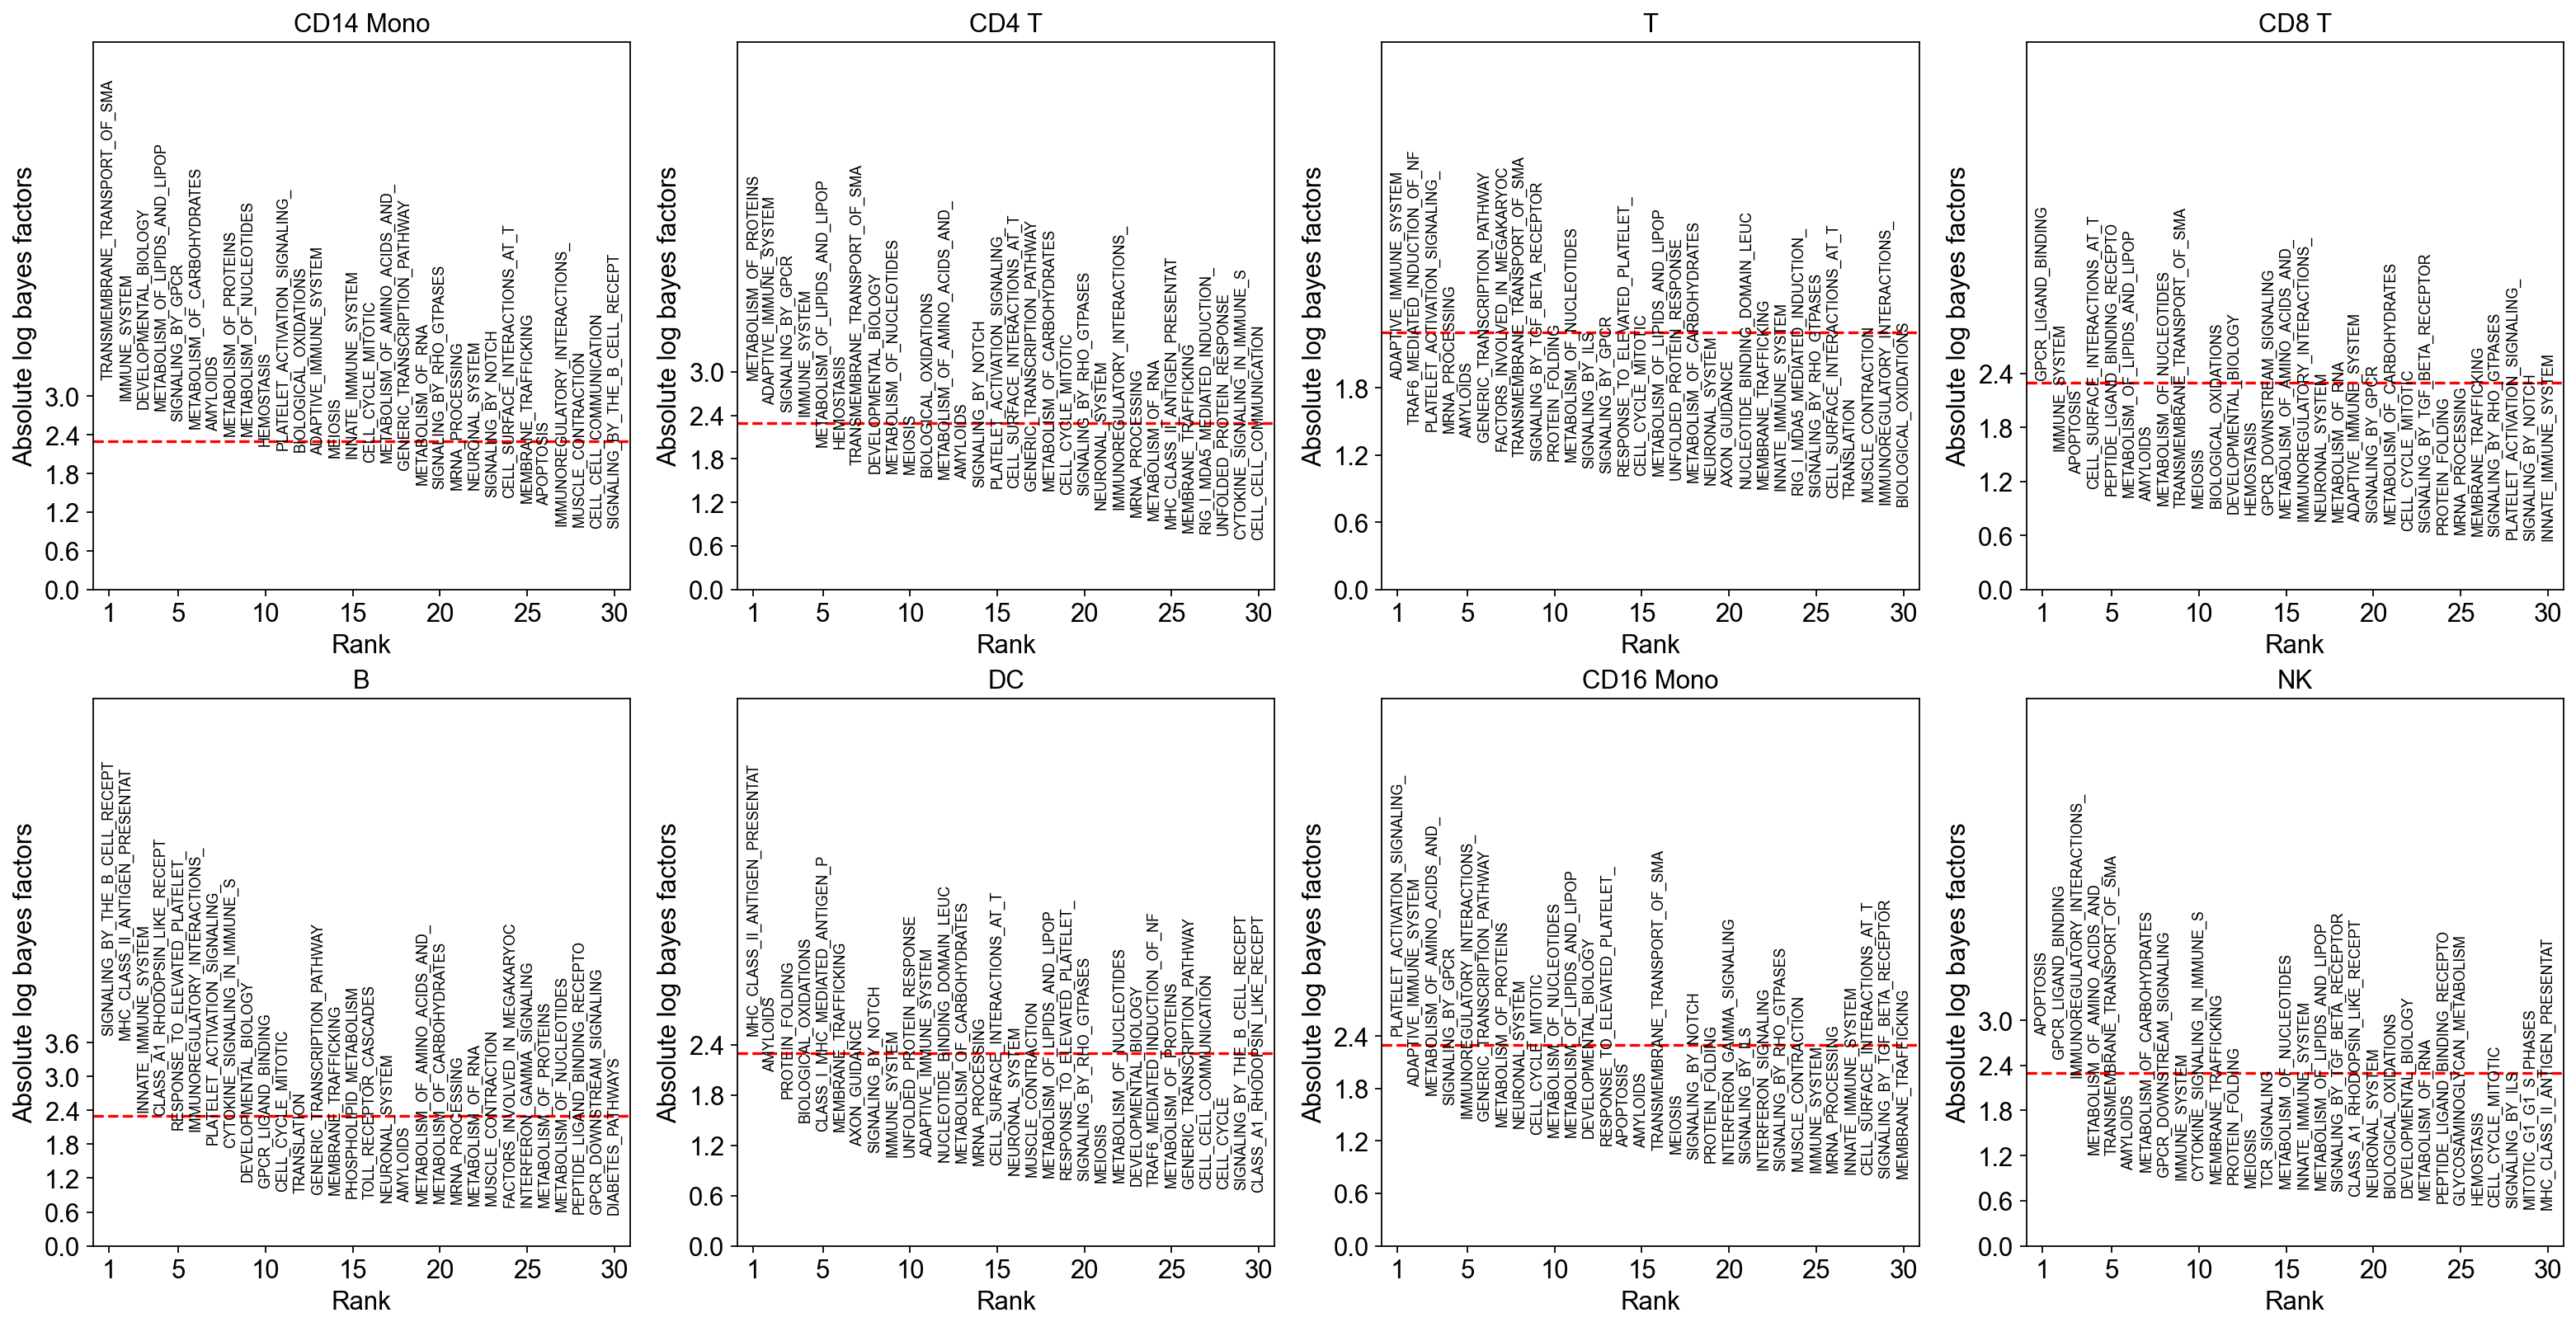

In [46]:
fig

In [47]:
idx = [terms.index(term) for term in ['INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPT', 'INTERFERON_ALPHA_BETA_SIGNALIN']]

In [48]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

In [49]:
kang.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

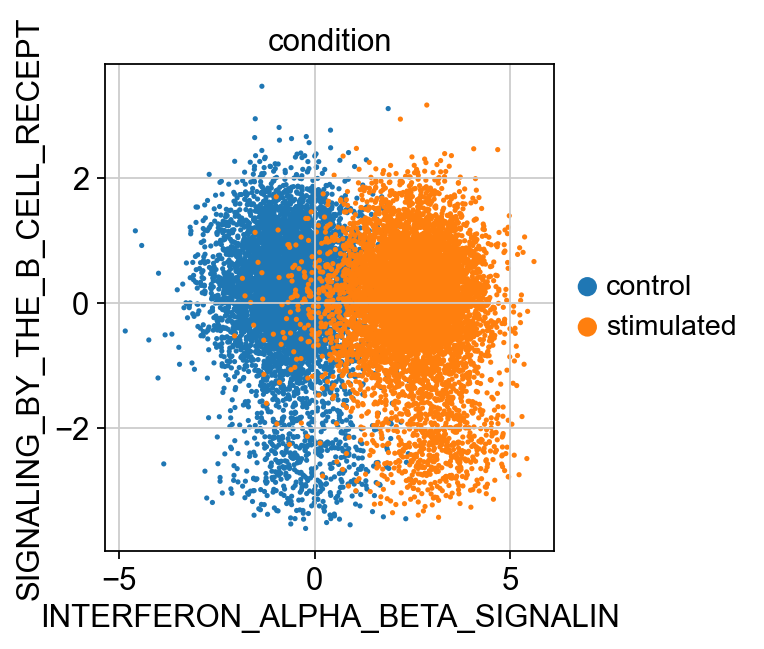

In [50]:
sc.pl.scatter(kang, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

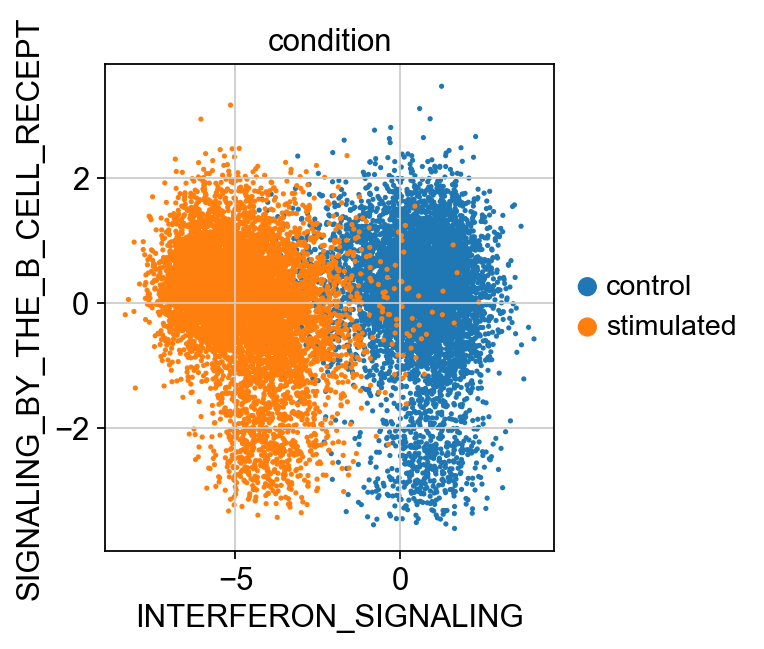

In [51]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

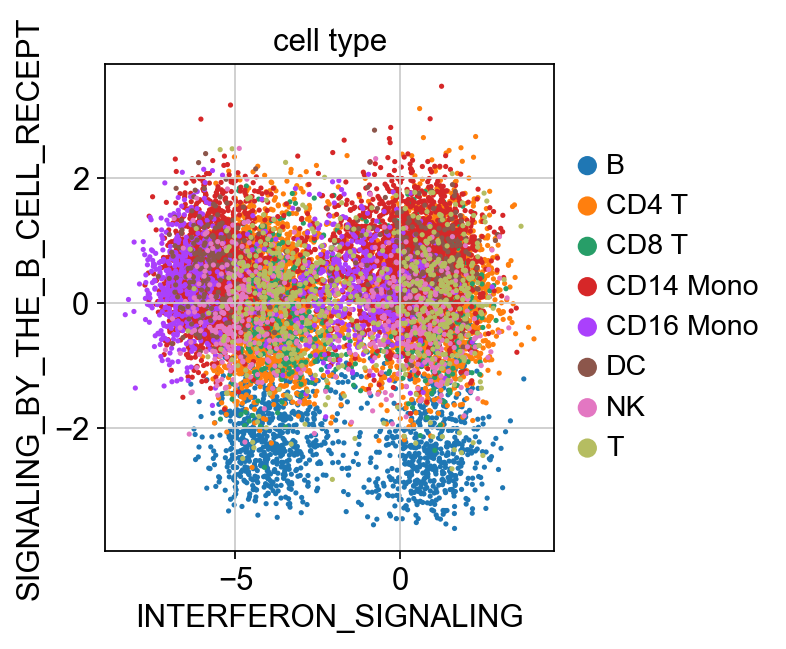

In [52]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=22)

In [53]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [54]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [55]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [56]:
kang_pbmc.strings_to_categoricals()

In [57]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [58]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [59]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [60]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [61]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [62]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

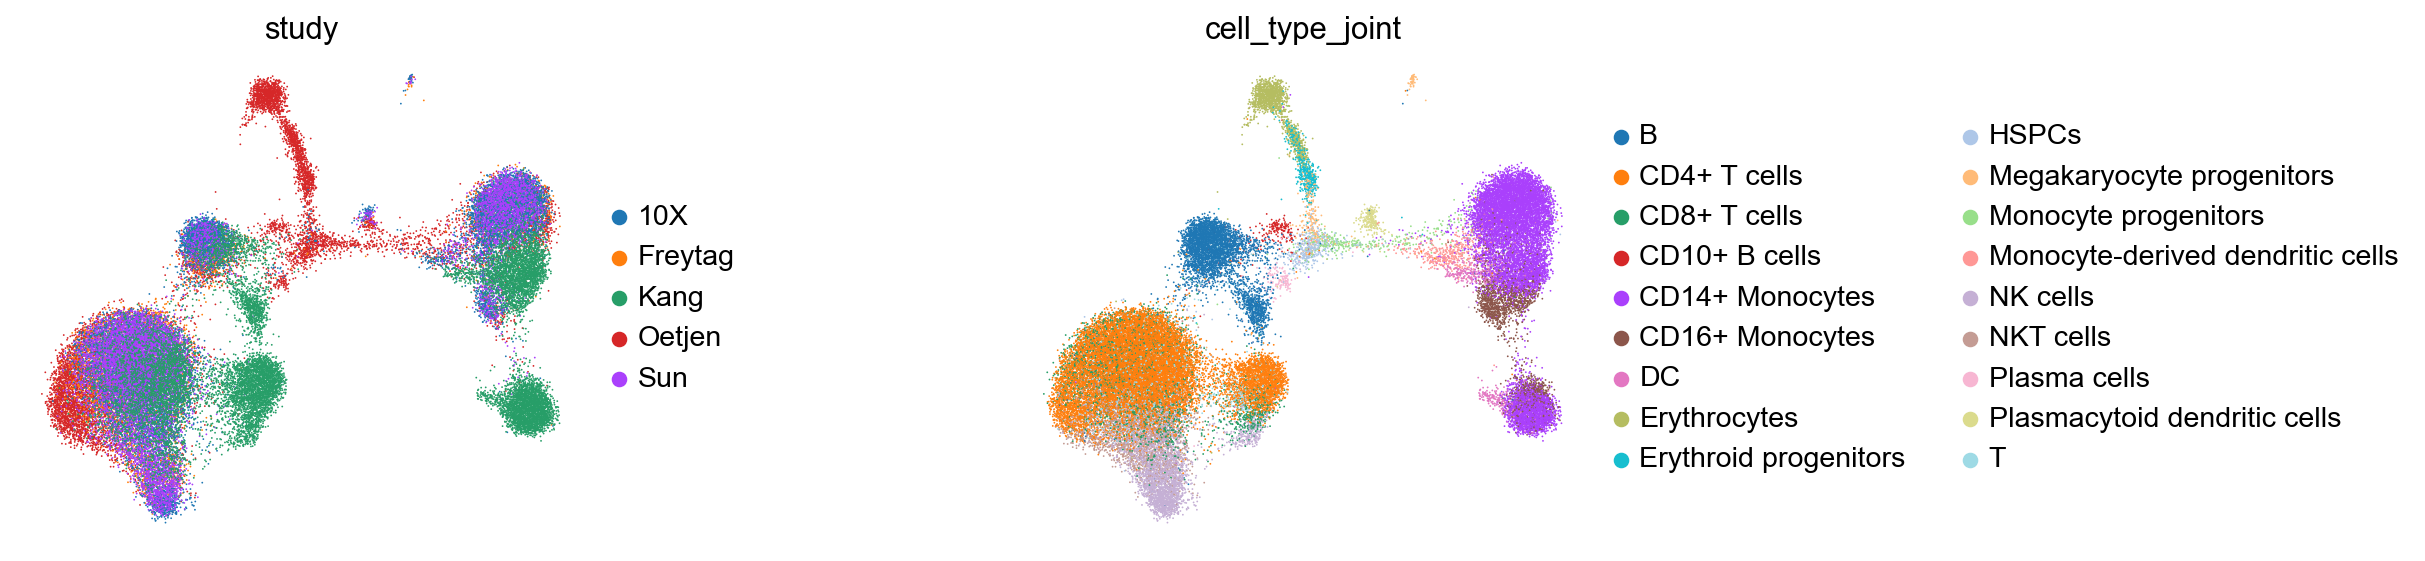

In [63]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

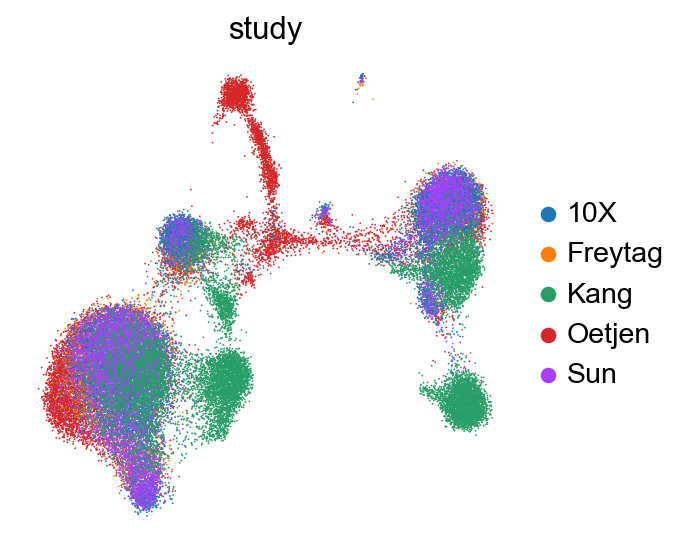

In [64]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

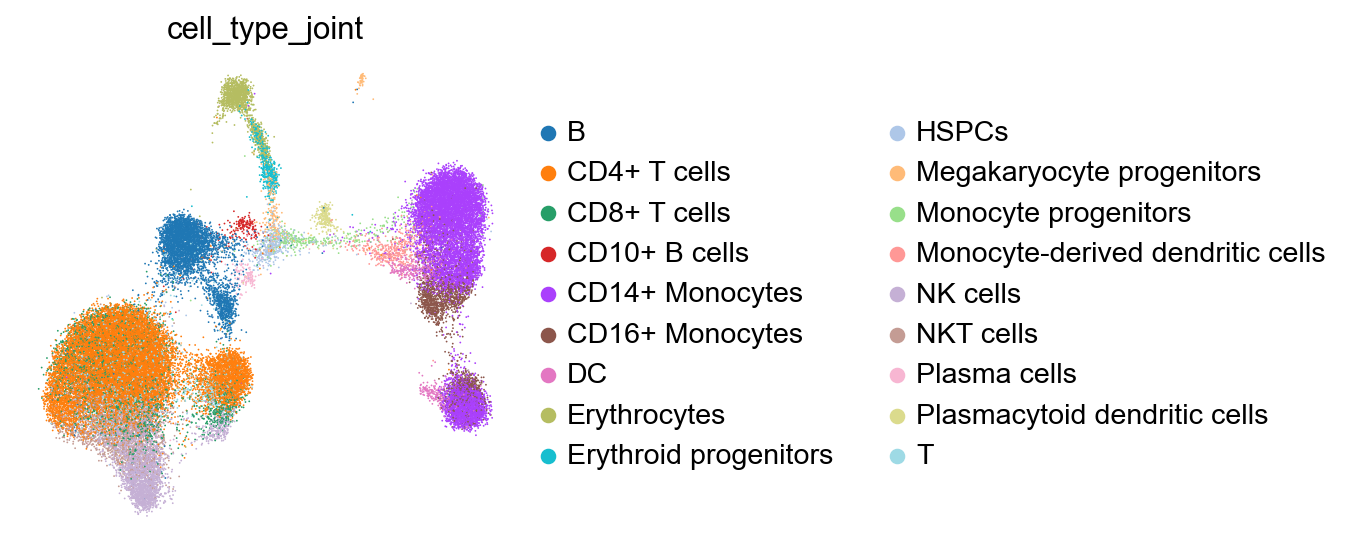

In [65]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

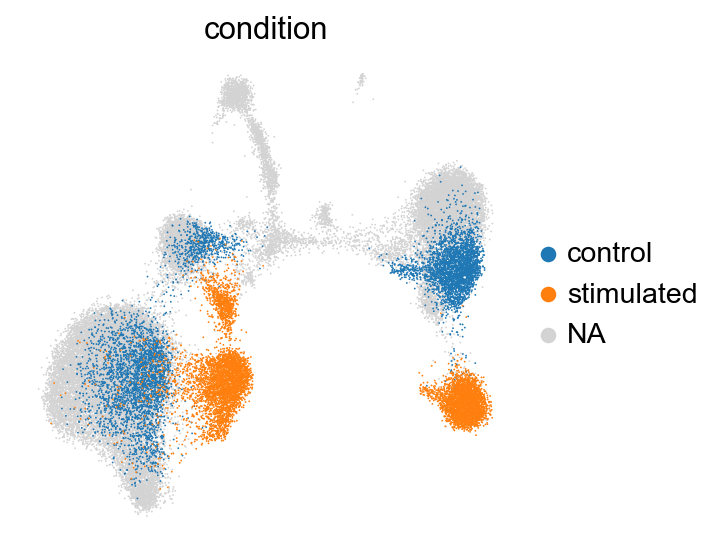

In [66]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [67]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs['condition'].copy()

In [68]:
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].isna()] = 'control'

In [69]:
scores_cond = q_intr_cvae.latent_enrich('condition_joint', comparison="control", adata=kang_pbmc, exact=True, n_perm=12000)

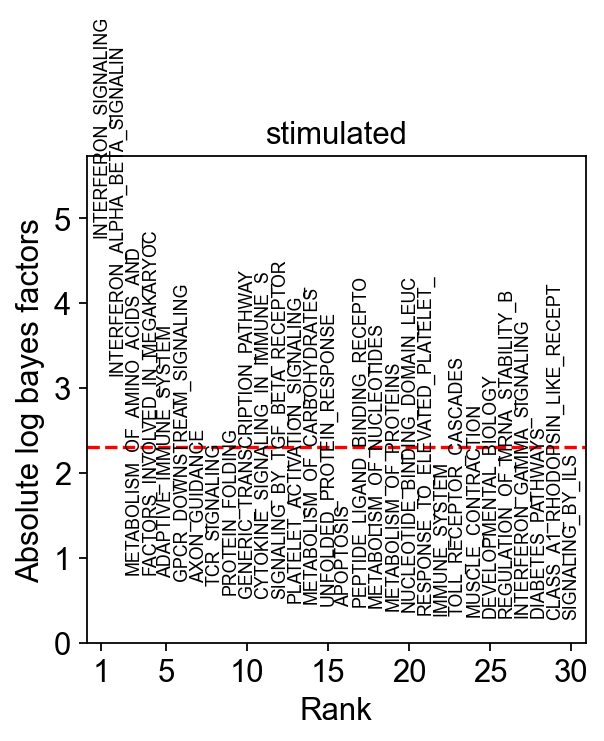

In [70]:
fig = sca.plotting.plot_abs_bfs(scores_cond, np.array(terms), keys='stimulated', yt_step=1, fontsize=8, scale_y=1.2)

In [71]:
kang_pbmc_ctrl = kang_pbmc[kang_pbmc.obs.condition_joint == "control"]

In [72]:
scores_ct = q_intr_cvae.latent_enrich('cell_type_joint', adata=kang_pbmc, n_perm=7000, exact=True)

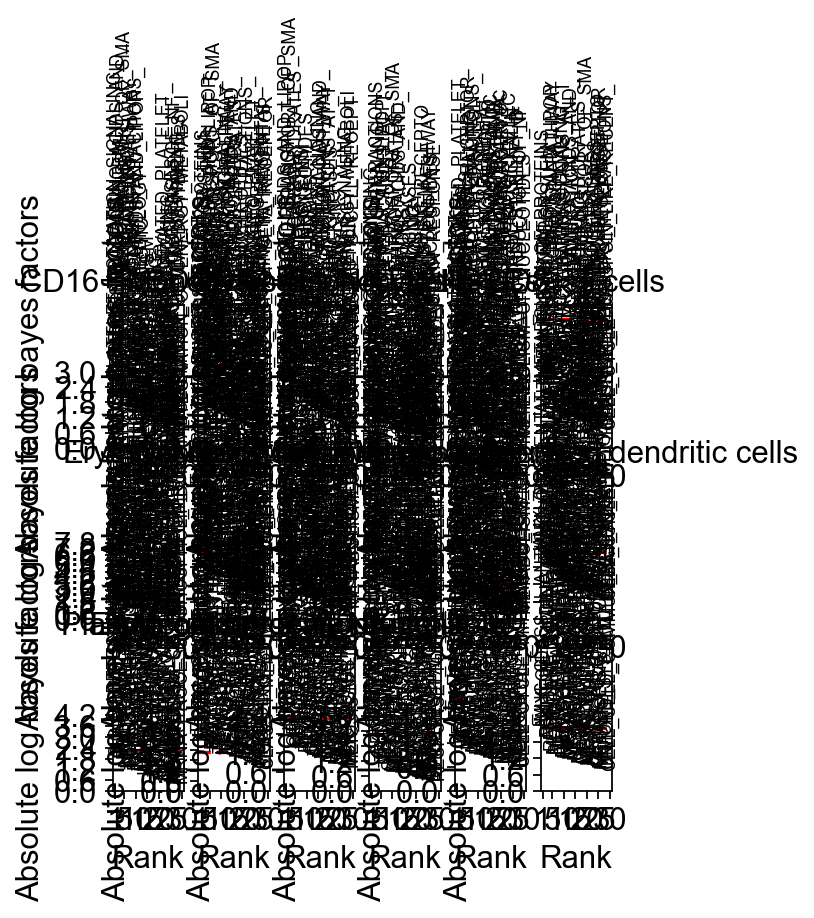

In [73]:
fig = sca.plotting.plot_abs_bfs(scores_ct, np.array(terms), n_cols=6, scale_y=2, yt_step=0.6)

In [74]:
fig.set_size_inches(40, 24)

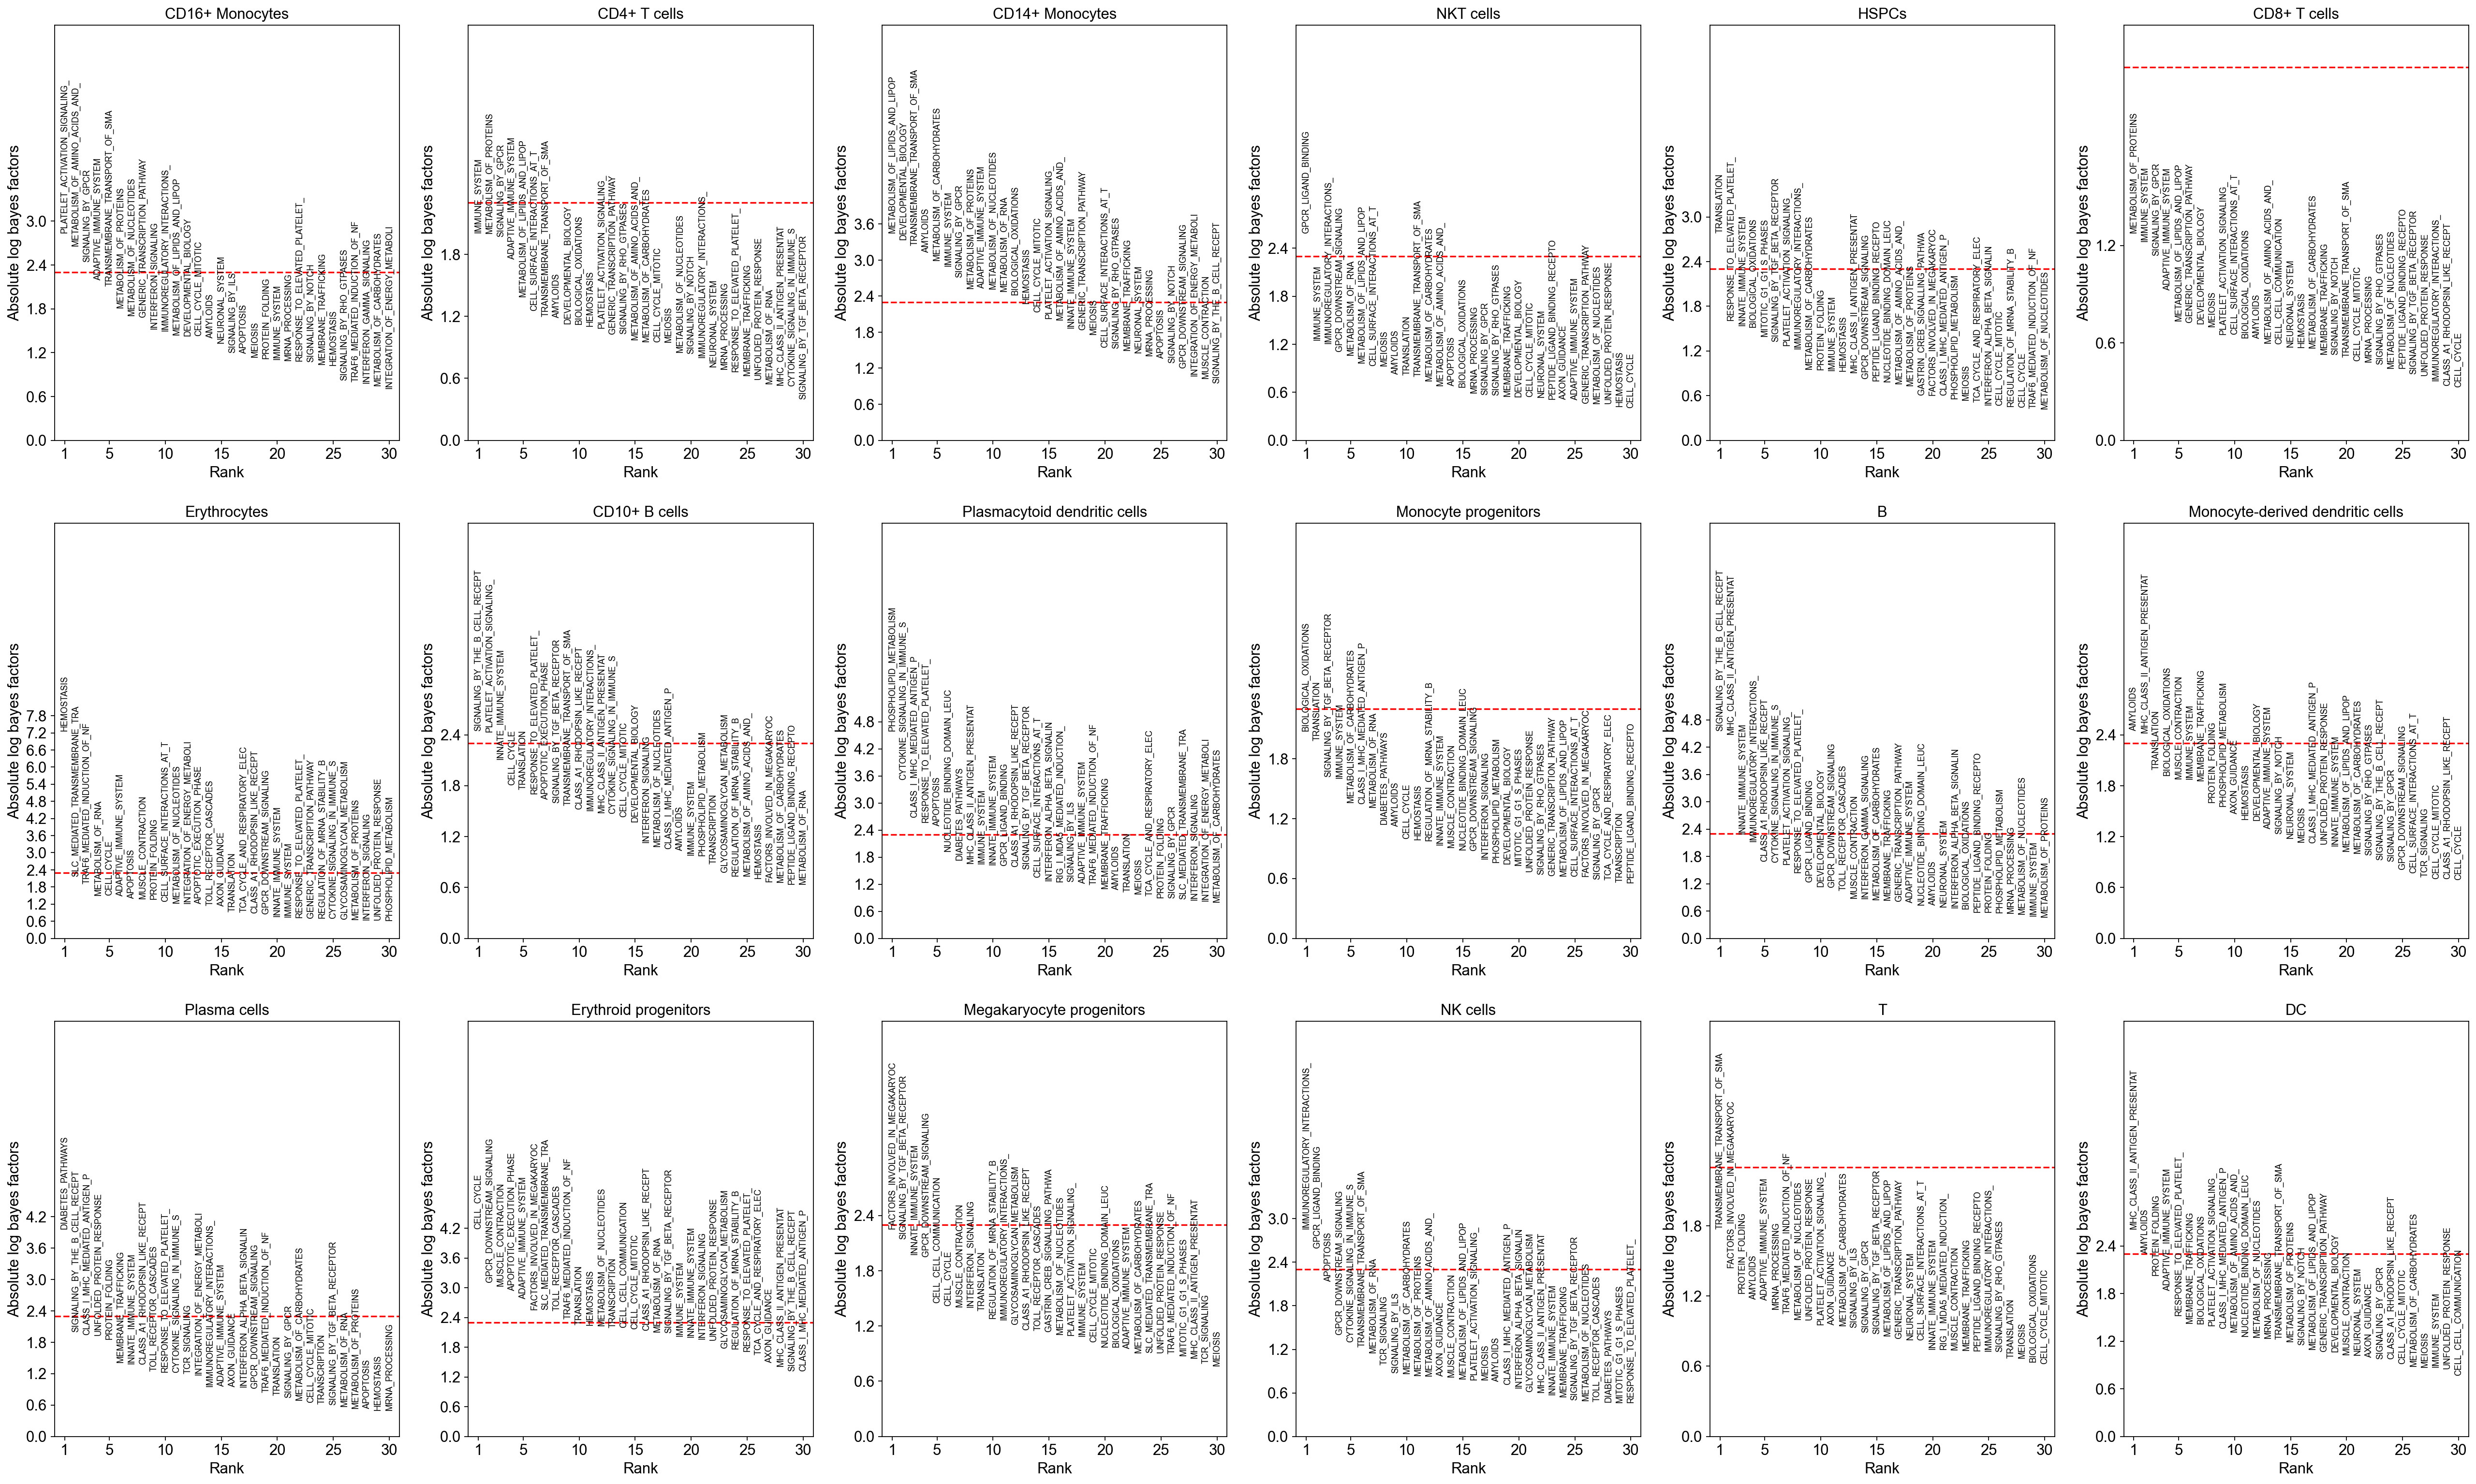

In [75]:
fig

In [76]:
kang_pbmc_mono = kang_pbmc[kang_pbmc.obs.cell_type_joint == "CD14+ Monocytes"]

In [77]:
scores_cond_mono = q_intr_cvae.latent_enrich('condition_joint', comparison="control", adata=kang_pbmc_mono, exact=True, n_perm=7000)

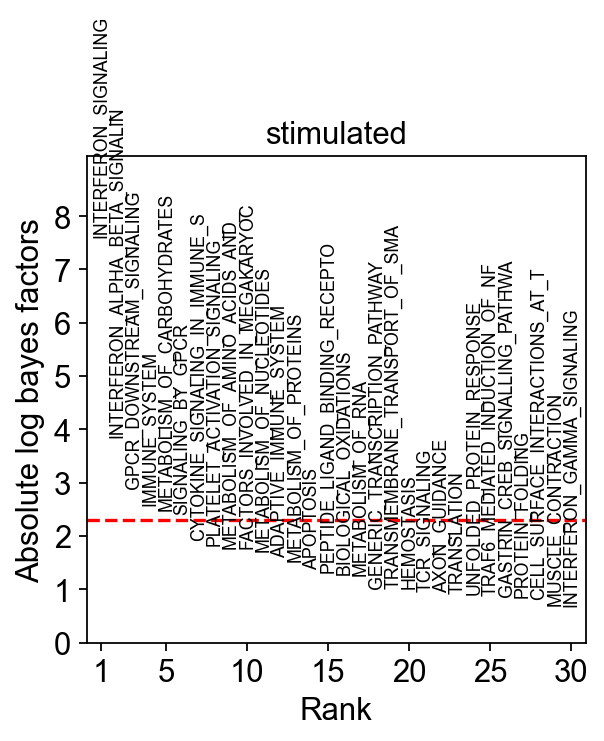

In [78]:
fig = sca.plotting.plot_abs_bfs(scores_cond_mono, np.array(terms), keys='stimulated', yt_step=1, fontsize=8, scale_y=1.2)